[![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/pixeltable/pixeltable/blob/master/docs/release/tutorials/audio-transcriptions.ipynb)&nbsp;&nbsp;
[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pixeltable/pixeltable/blob/master/docs/release/tutorials/audio-transcriptions.ipynb)

# Transcribing and Indexing Audio and Video in Pixeltable

In this tutorial, we'll build an end-to-end workflow for creating and indexing audio transcriptions of video data. We'll demonstrate how Pixeltable can be used to:
1) Extract audio data from video files;
2) Transcribe the audio using OpenAI Whisper;
3) Build a semantic index of the transcriptions, using the Huggingface sentence_transformers models;
4) Search this index.

The tutorial assumes you're already somewhat familiar with Pixeltable. If this is your first time using Pixeltable, the [Pixeltable Basics](https://pixeltable.readme.io/docs/pixeltable-basics) tutorial is a great place to start.

## Create a Table for Video Data

Let's first install the Python packages we'll need for the demo. We're going to use the popular Whisper library, running locally. Later in the demo, we'll see how to use the OpenAI API endpoints as an alternative.

In [ ]:
%pip install -q pixeltable openai openai-whisper sentence-transformers

Now we create a Pixeltable table to hold our videos.

In [1]:
import numpy as np
import pixeltable as pxt

# Create a directory and do some cleanup
pxt.create_dir('transcription_demo', ignore_errors=True)
pxt.drop_table('transcription_demo.sentences_view', ignore_errors=True)
pxt.drop_table('transcription_demo.video_table', ignore_errors=True)

# Create a table to store our videos and workflow
video_table = pxt.create_table('transcription_demo.video_table', {'video': pxt.VideoType()})
video_table

Connected to Pixeltable database at: postgresql://postgres:@/pixeltable?host=/Users/asiegel/.pixeltable/pgdata
Created table `video_table`.


table 'video_table'

Column Name  Type Computed With
      video video

Next let's insert some video files into the table. In this demo, we'll be using one-minute excerpts from a Lex Fridman podcast. We'll begin by inserting two of them into our new table. In this demo, our videos are given as `https` links, but Pixeltable also accepts local files and S3 URLs as input.

Inserting rows into `video_table`: 2 rows [00:00, 728.30 rows/s]
Inserted 2 rows with 0 errors.


video
0  /Users/asiegel/.pixeltable/file_cache/7c7641bd...
1  /Users/asiegel/.pixeltable/file_cache/7c7641bd...
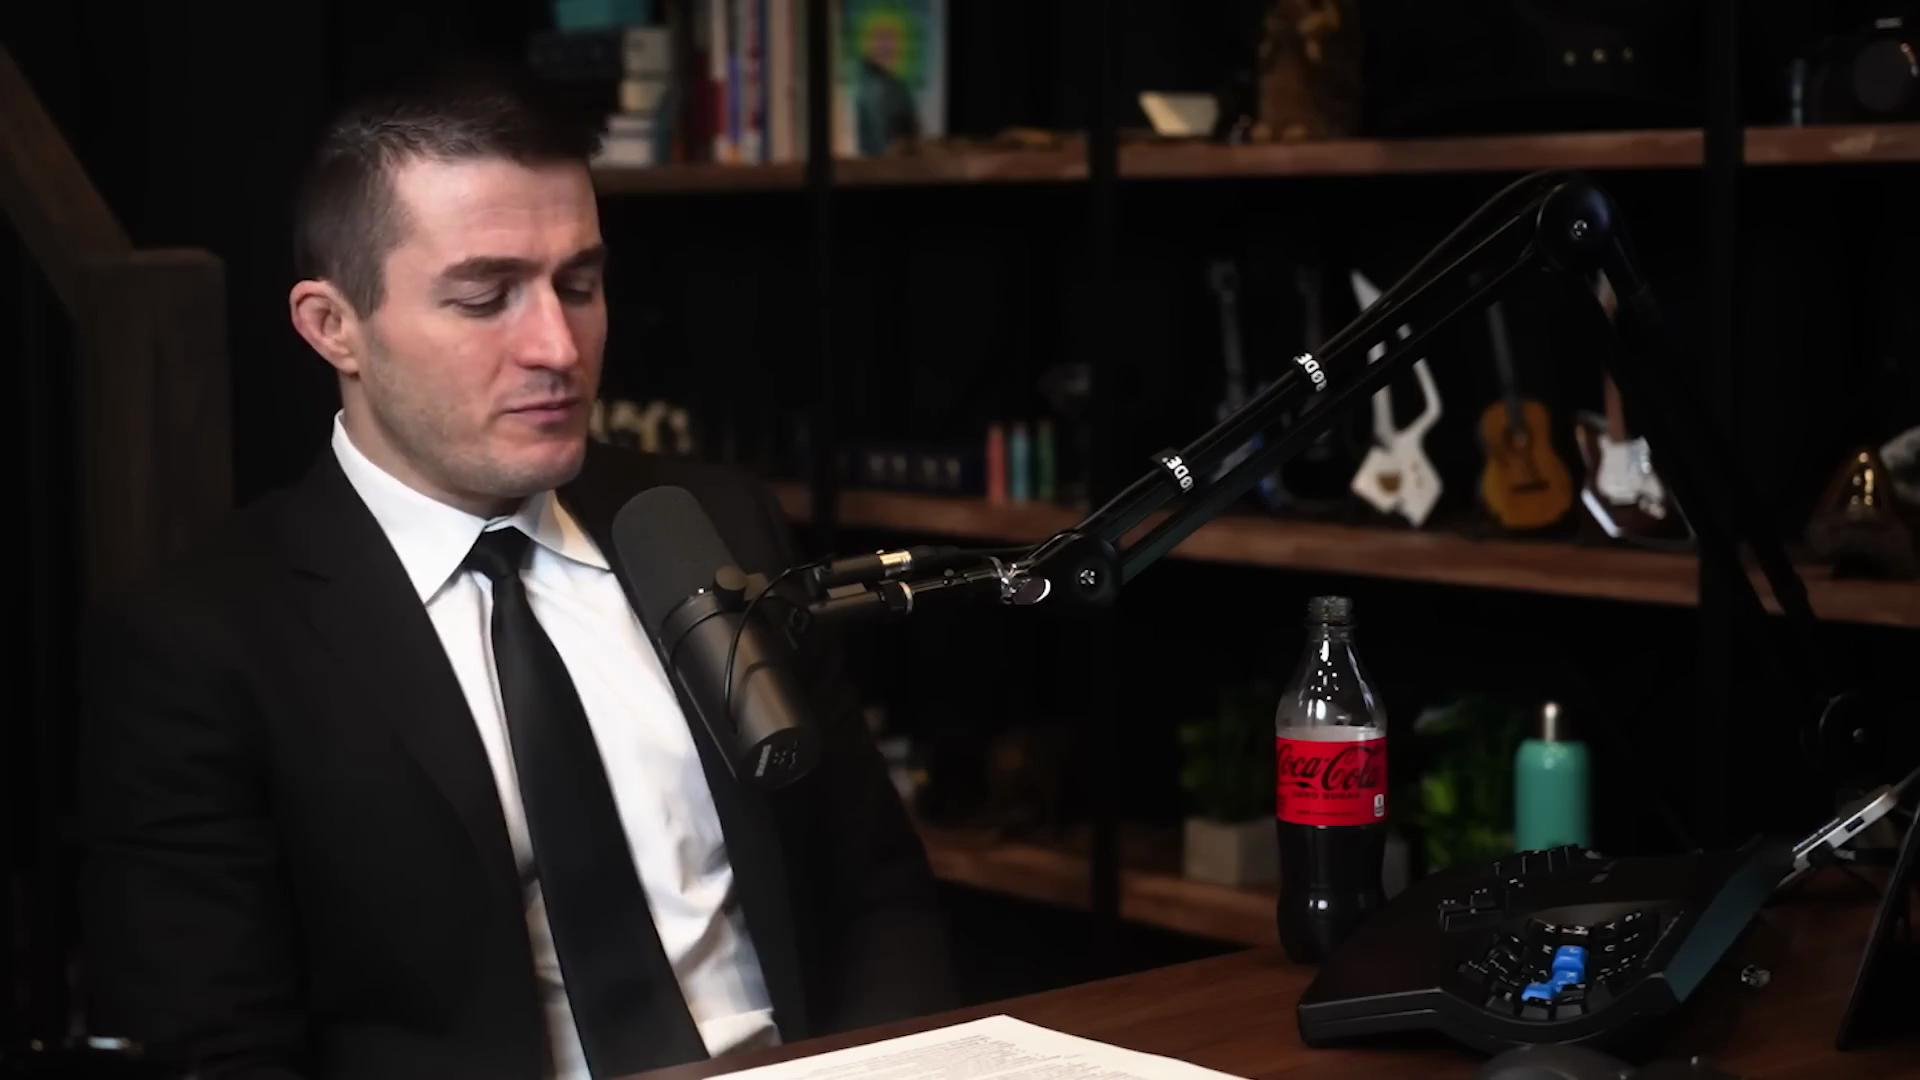
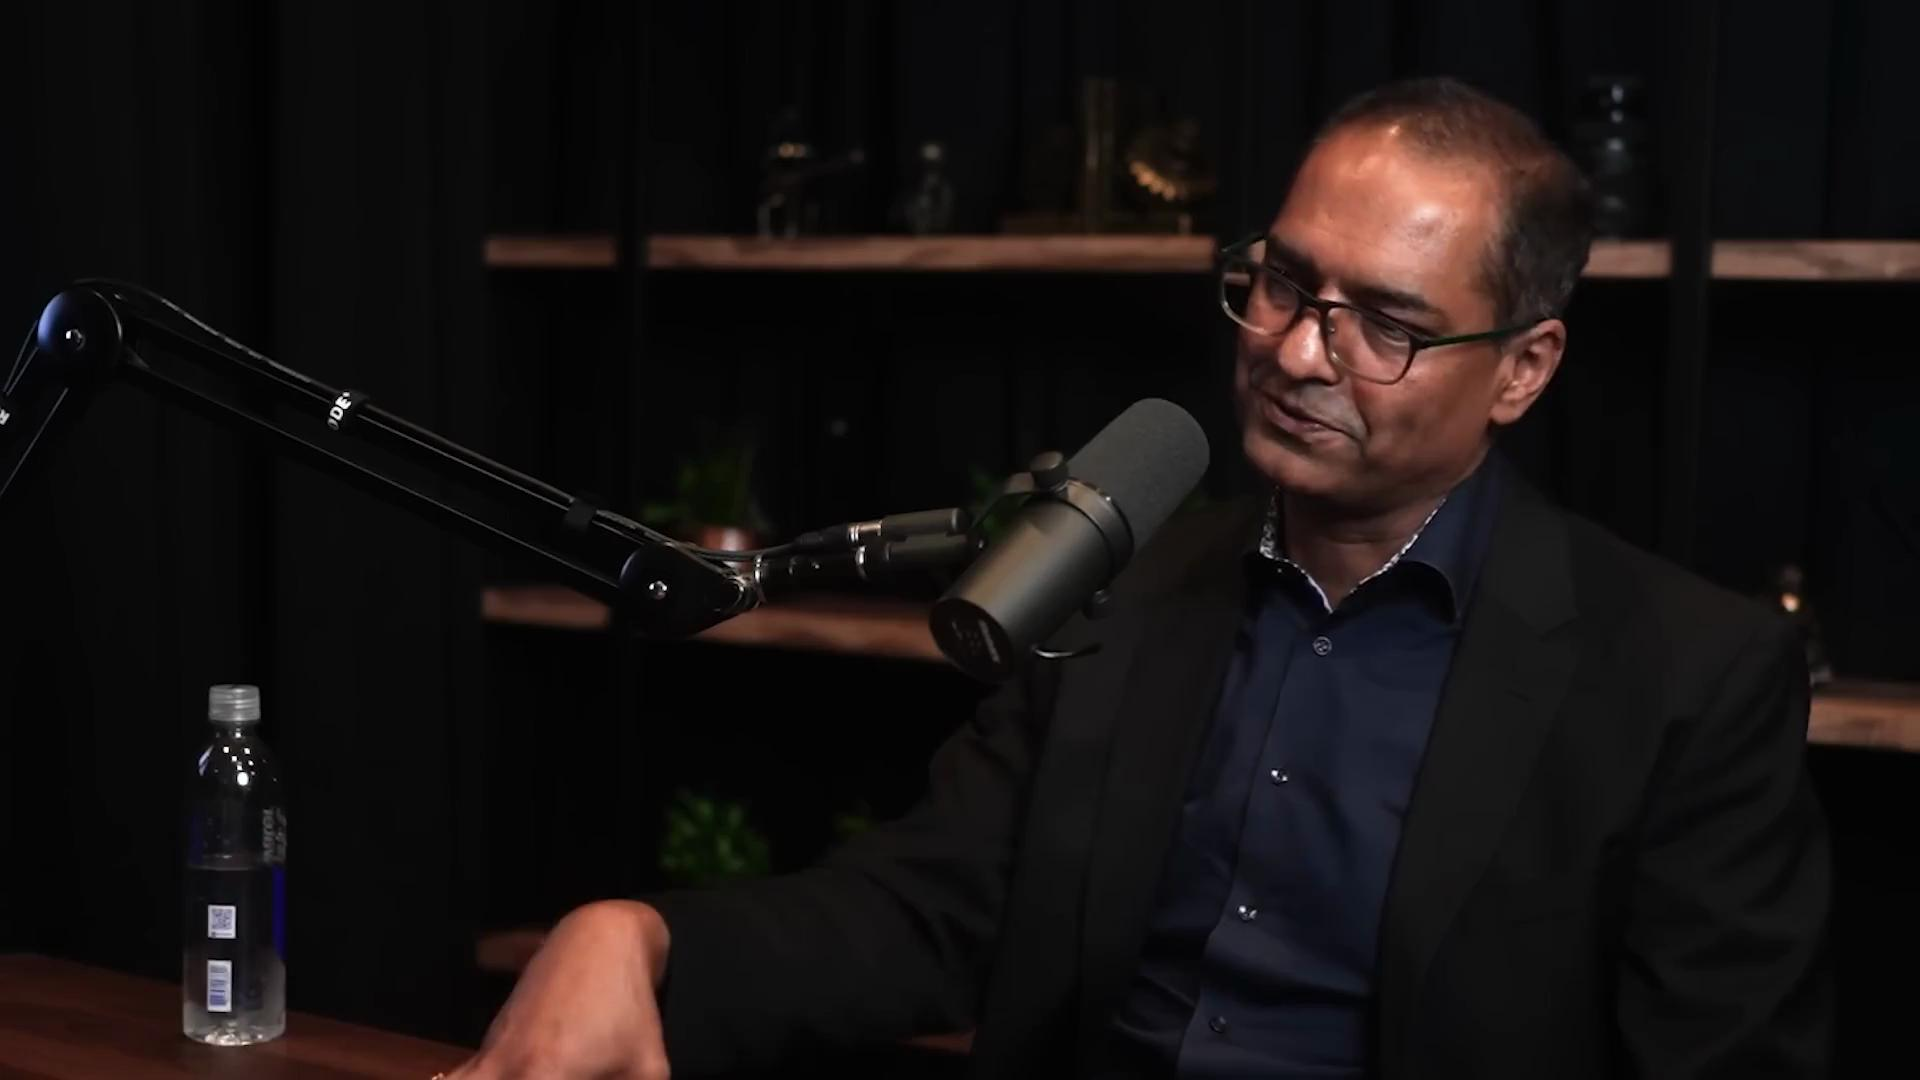

In [2]:
videos = [
    'https://github.com/pixeltable/pixeltable/raw/master/docs/source/data/audio-transcription-demo/'
    f'Lex-Fridman-Podcast-430-Excerpt-{n}.mp4'
    for n in range(3)
]

video_table.insert({'video': video} for video in videos[:2])
video_table.show()

Now we'll add another column to hold extracted audio from our videos. The new column is an example of a _computed column_: it's updated automatically based on the contents of another column (or columns). In this case, the value of the `audio` column is defined to be the audio track extracted from whatever's in the `video` column.

Computing cells: 100%|████████████████████████████████████████████| 2/2 [00:00<00:00,  2.17 cells/s]
Added 2 column values with 0 errors.


video  \
0  /Users/asiegel/.pixeltable/file_cache/7c7641bd...   
1  /Users/asiegel/.pixeltable/file_cache/7c7641bd...   

                                               audio  
0  /Users/asiegel/.pixeltable/media/591c5fb93bab4...  
1  /Users/asiegel/.pixeltable/media/591c5fb93bab4...
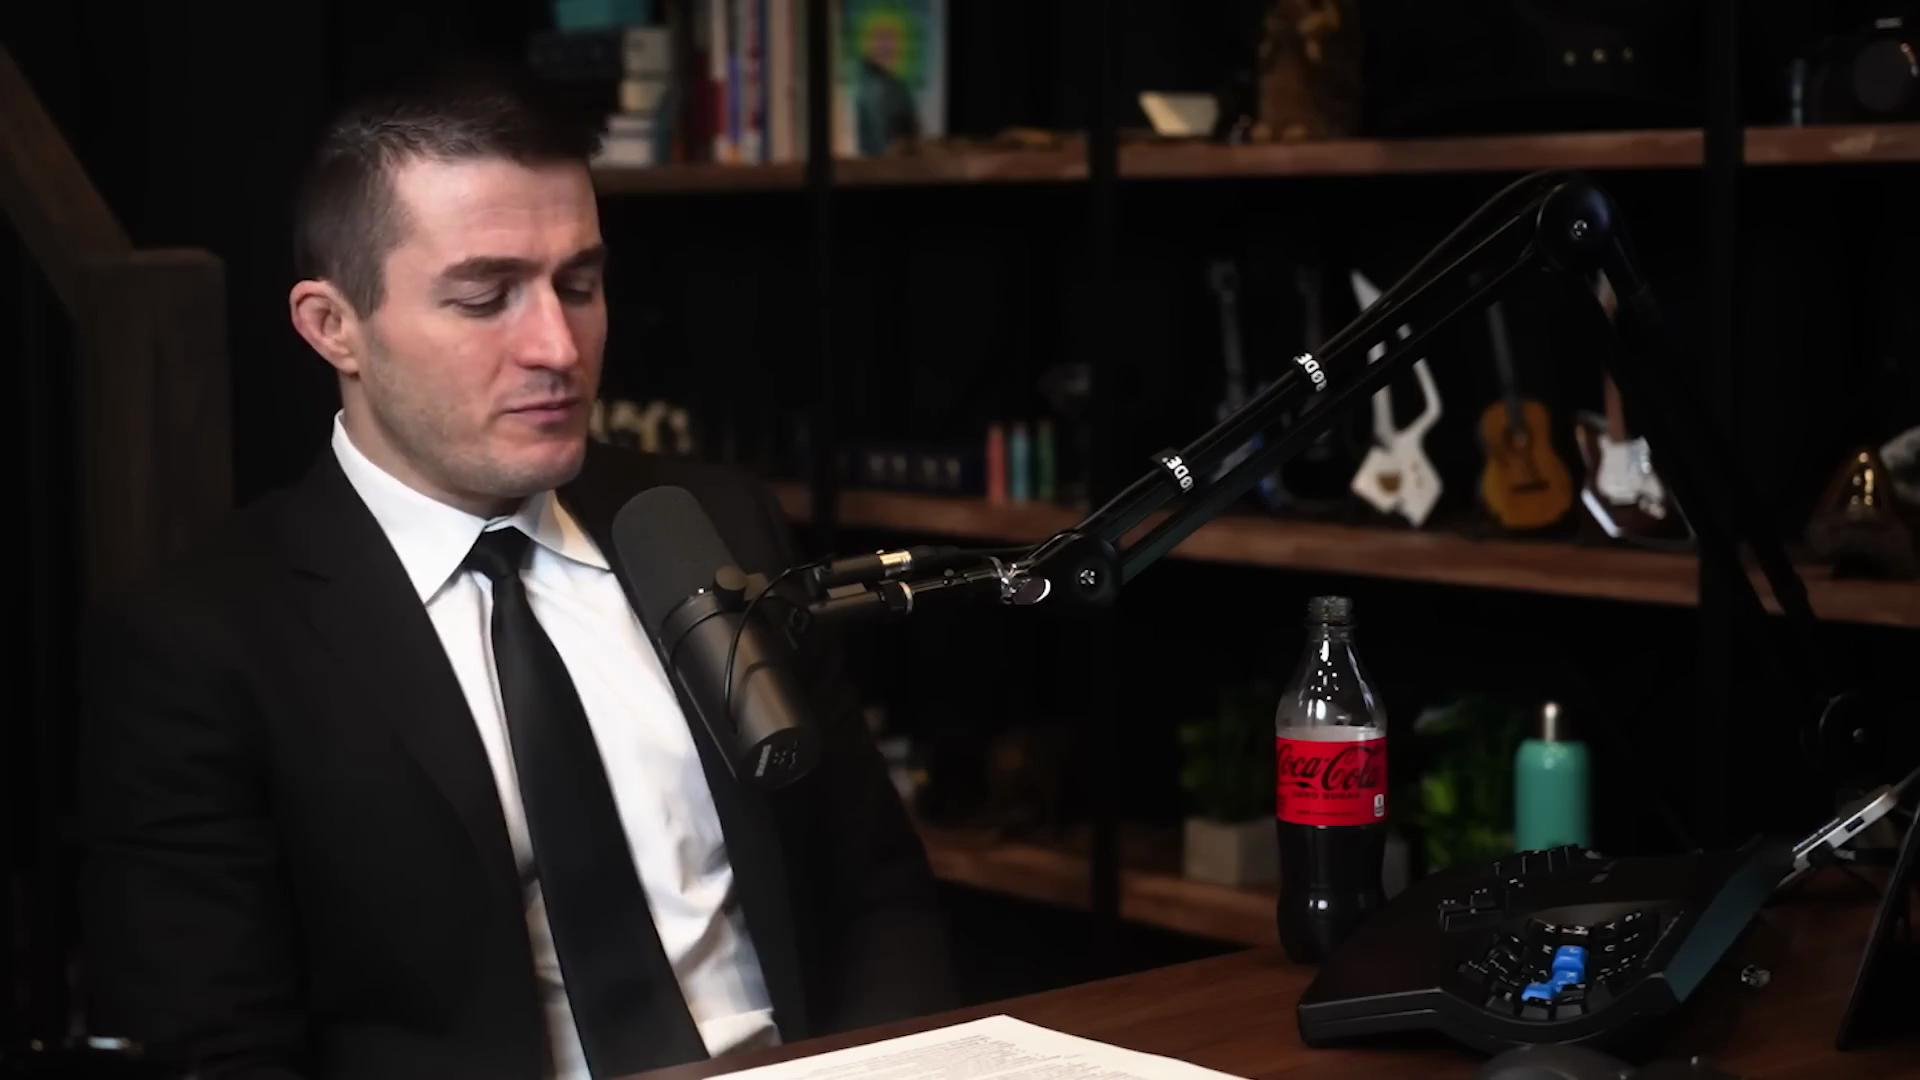
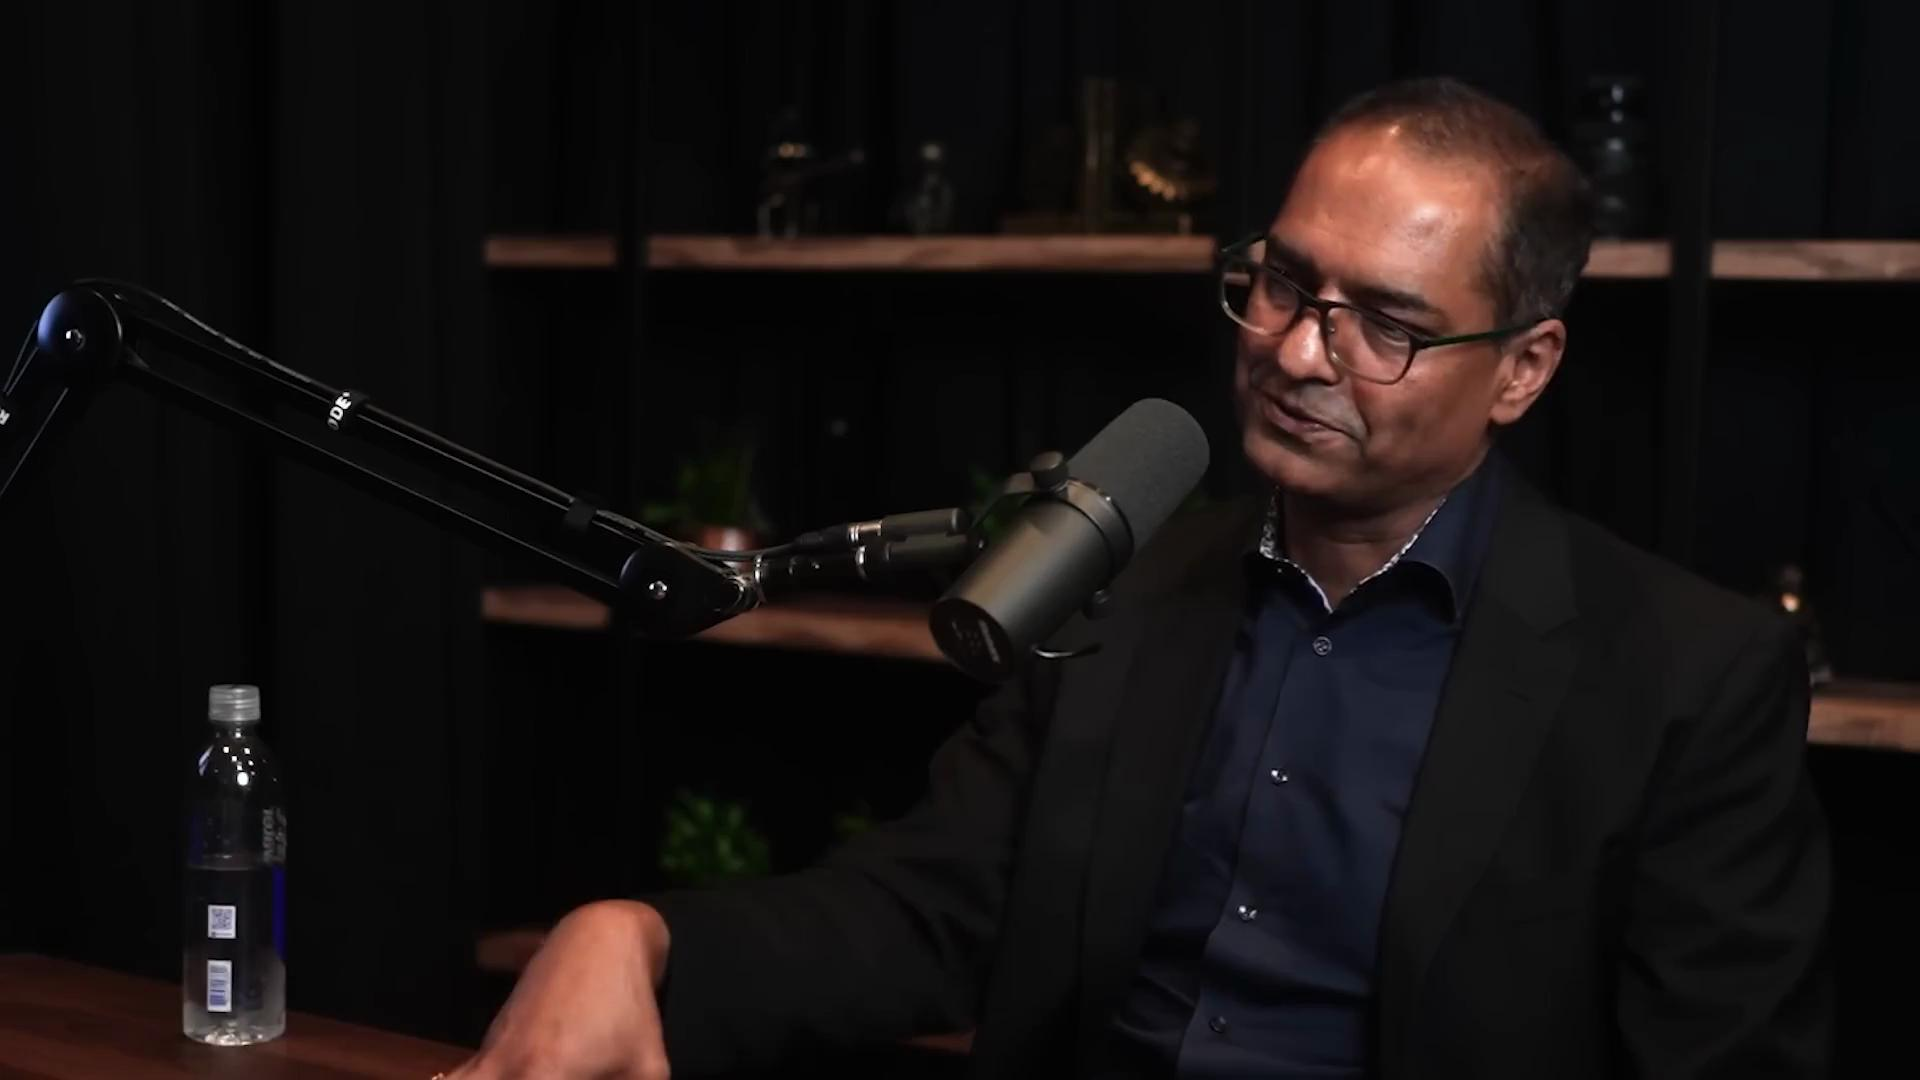

In [3]:
from pixeltable.functions.video import extract_audio

video_table['audio'] = extract_audio(video_table.video, format='mp3')
video_table.show()

If we look at the structure of the video table, we see that the new column is a computed column.

In [4]:
video_table

table 'video_table'

Column Name  Type                      Computed With
      video video                                   
      audio audio extract_audio(video, format='mp3')

We can also add another computed column to extract metadata from the audio streams.

Computing cells: 100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 211.36 cells/s]
Added 2 column values with 0 errors.


video  \
0  /Users/asiegel/.pixeltable/file_cache/7c7641bd...   
1  /Users/asiegel/.pixeltable/file_cache/7c7641bd...   

                                               audio  \
0  /Users/asiegel/.pixeltable/media/591c5fb93bab4...   
1  /Users/asiegel/.pixeltable/media/591c5fb93bab4...   

                                            metadata  
0  {'size': 959276, 'streams': [{'type': 'audio',...  
1  {'size': 959276, 'streams': [{'type': 'audio',...
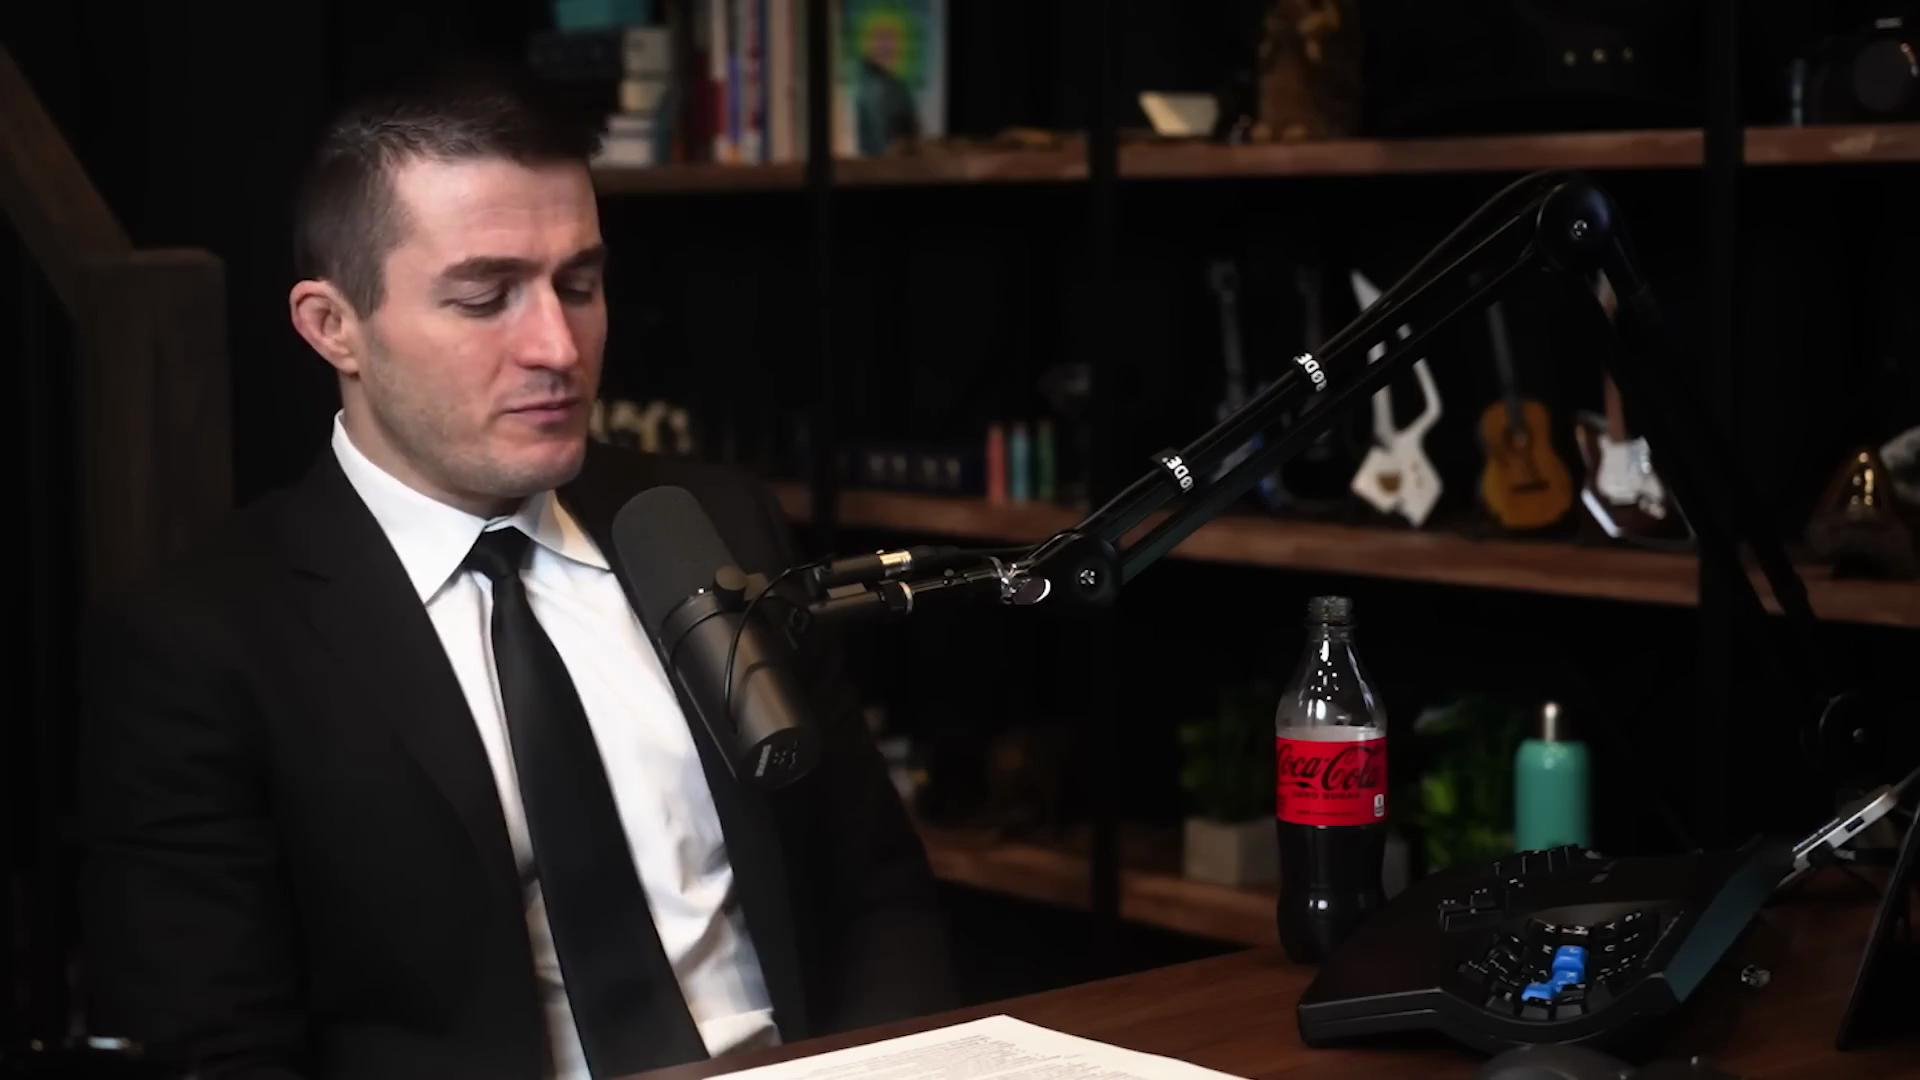
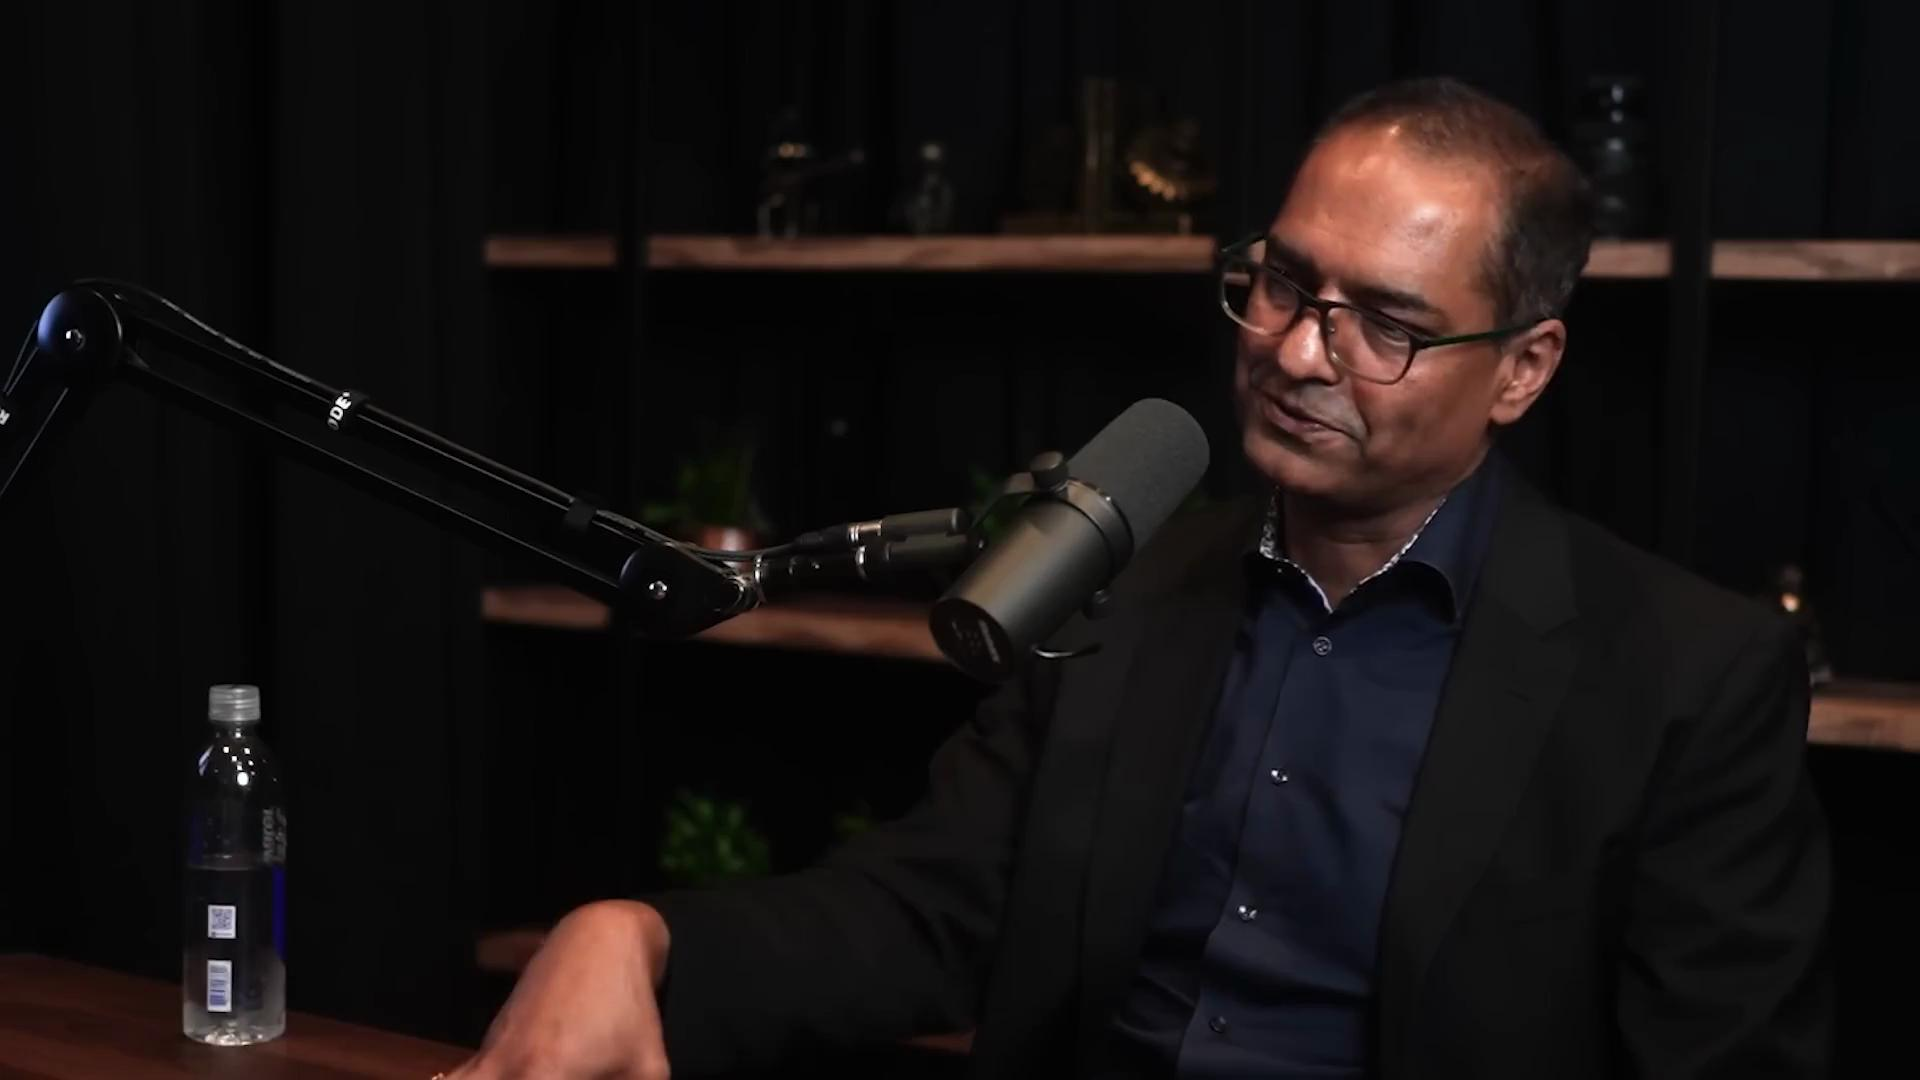

In [5]:
from pixeltable.functions.video import get_metadata

video_table['metadata'] = get_metadata(video_table.audio)
video_table.show()

## Create Transcriptions

Now we'll add a step to create transcriptions of our videos. As mentioned above, we're going to use the Whisper library for this, running locally. Pixeltable has a built-in function, `whisper.transcribe`, that serves as an adapter for the Whisper library's transcription capability. All we have to do is add a computed column that calls this function:

Computing cells: 100%|████████████████████████████████████████████| 2/2 [00:10<00:00,  5.32s/ cells]
Added 2 column values with 0 errors.


video  \
0  /Users/asiegel/.pixeltable/file_cache/7c7641bd...   
1  /Users/asiegel/.pixeltable/file_cache/7c7641bd...   

                                  transcription_text  
0   of experiencing self versus remembering self....  
1   worse, the young adults had episodic memory. ...
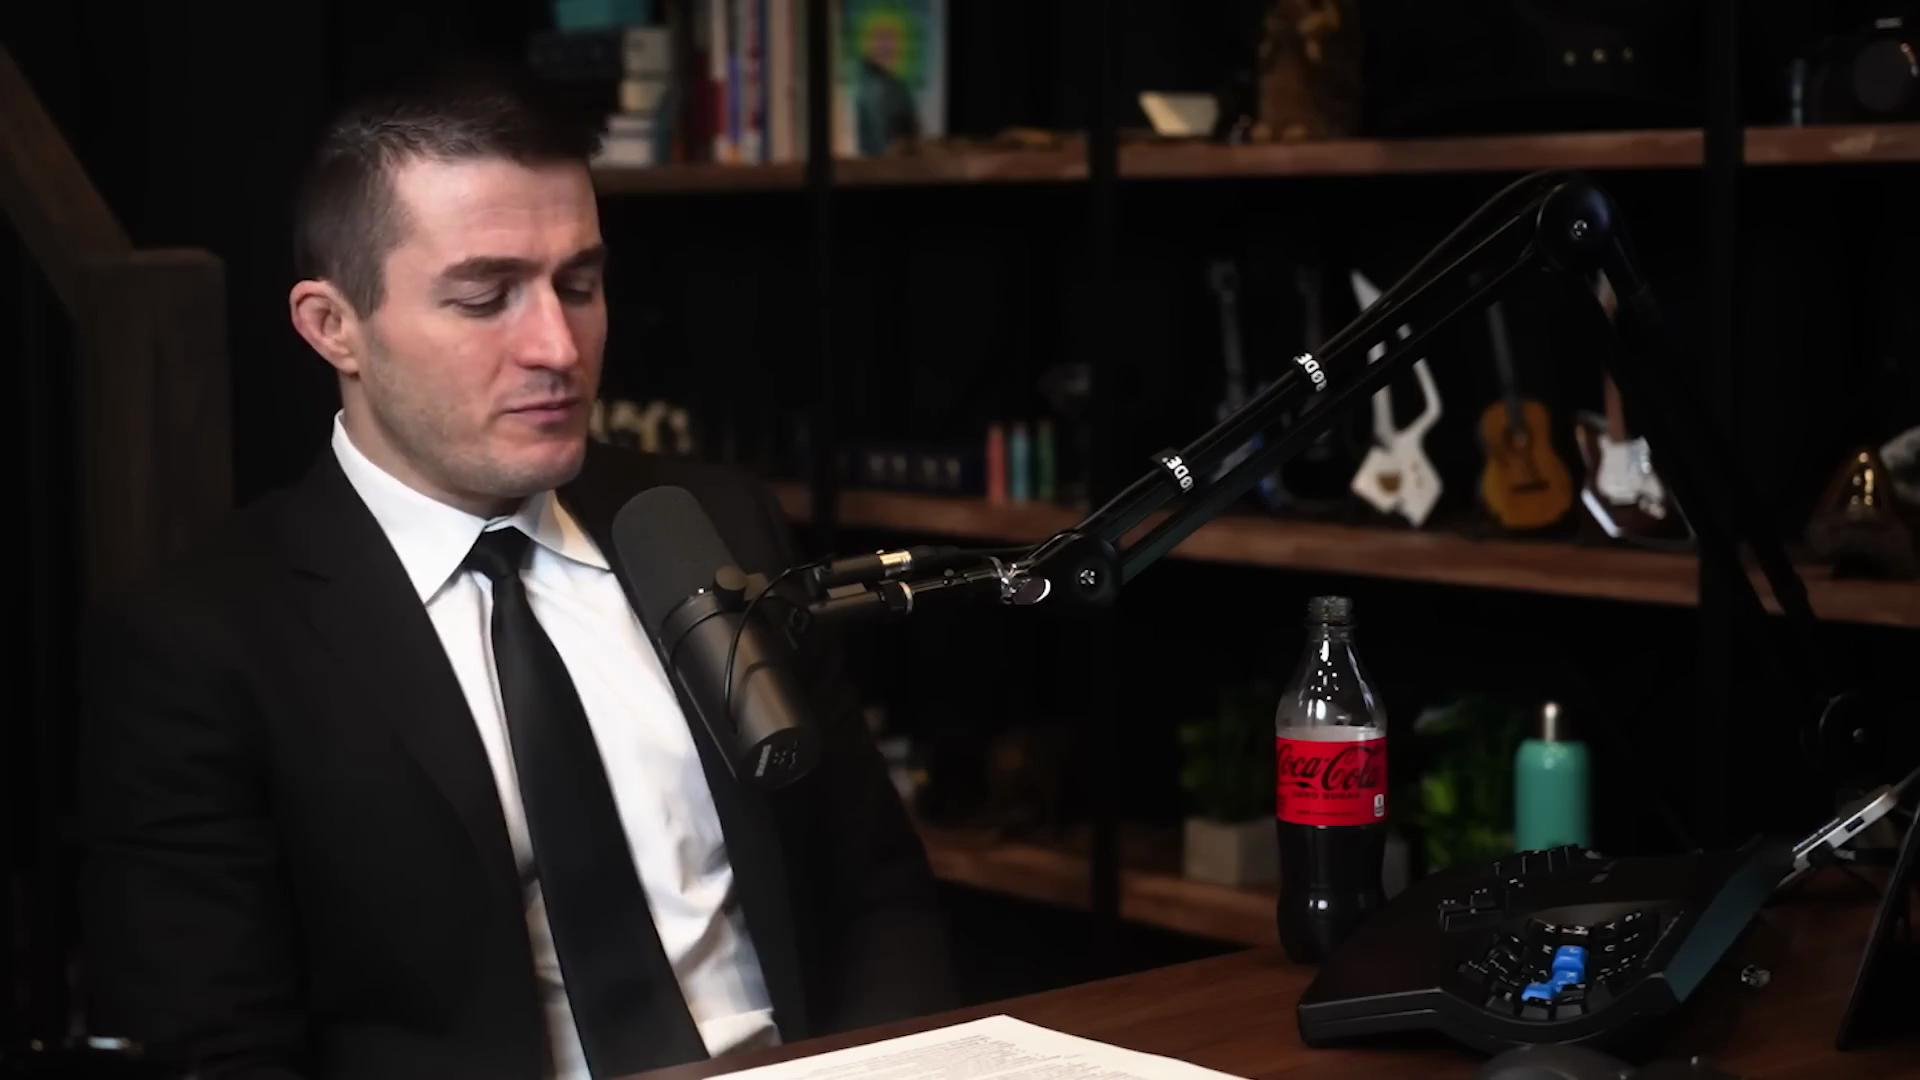
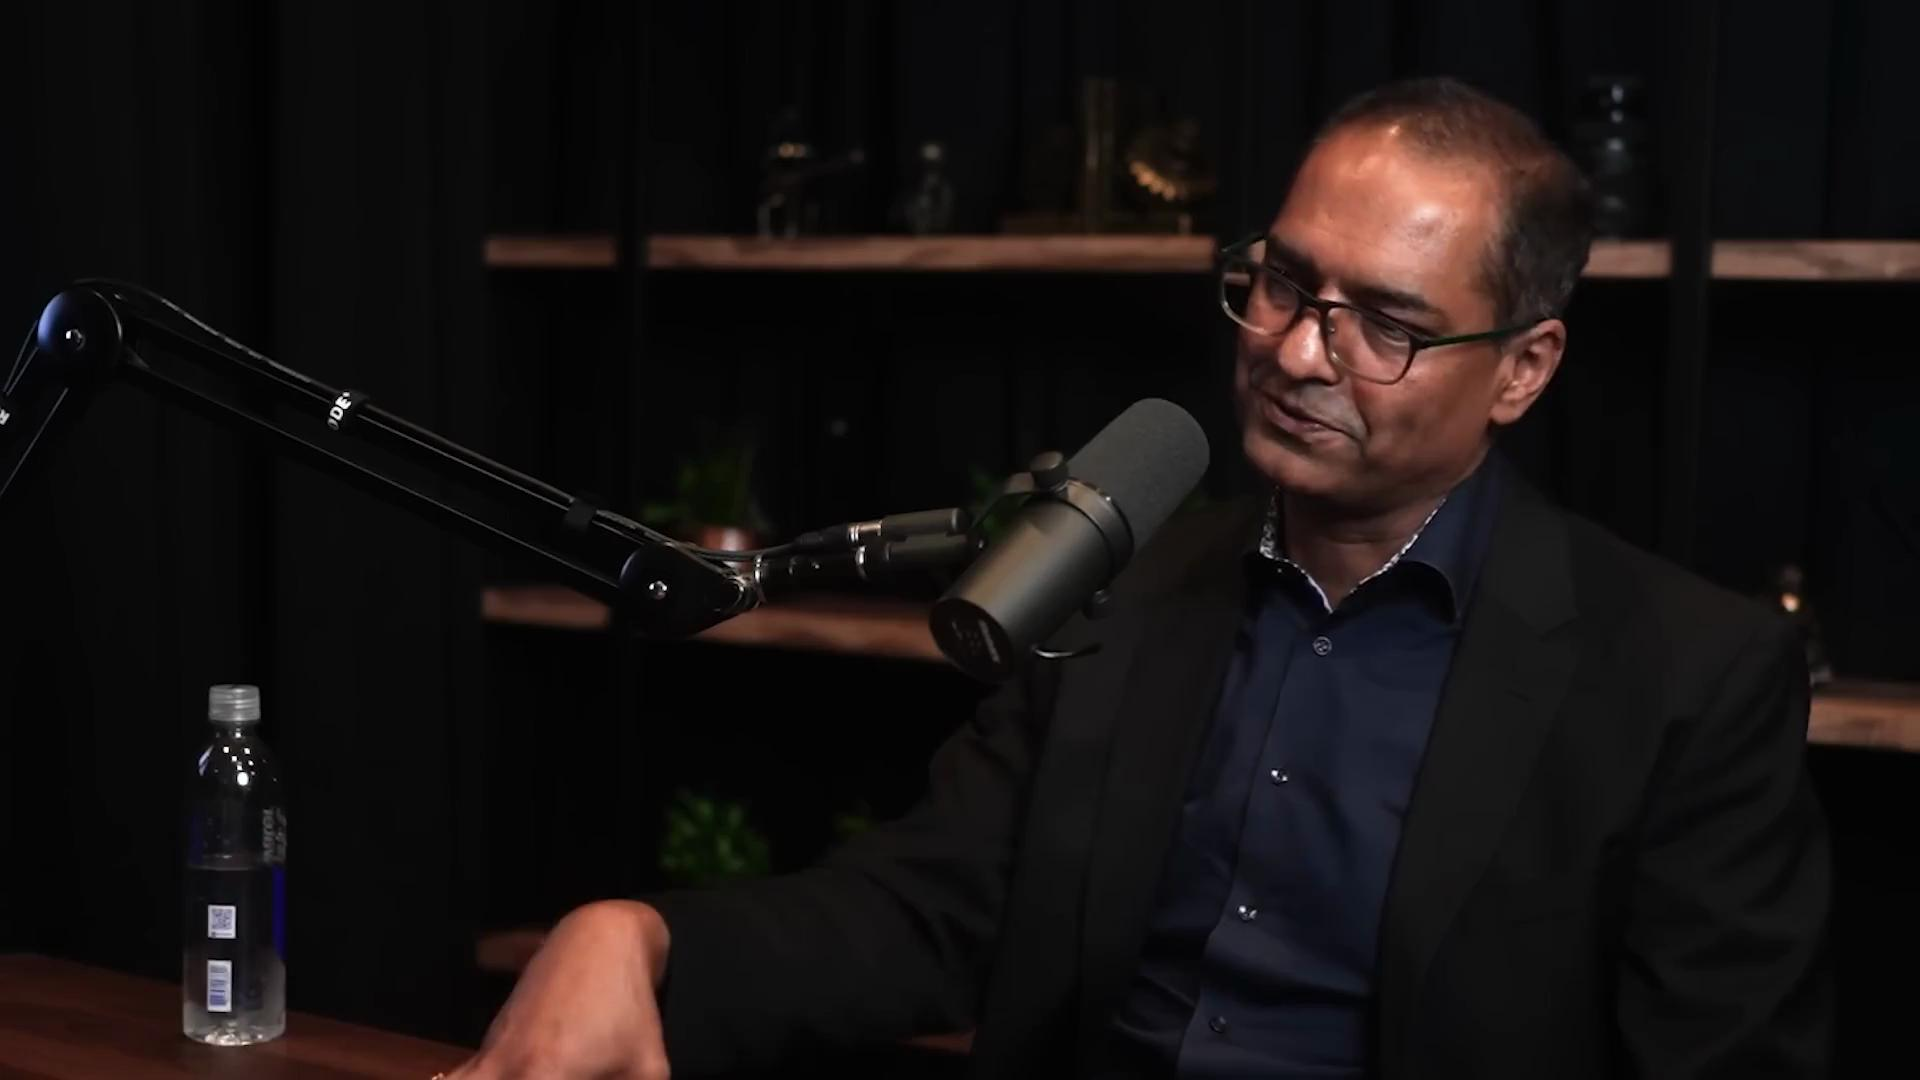

In [6]:
from pixeltable.functions import whisper

video_table['transcription'] = whisper.transcribe(audio=video_table.audio, model='base.en')
video_table.select(video_table.video, video_table.transcription.text).show()

In order to index the transcriptions, we'll first need to split them into sentences. We can do this using Pixeltable's built-in `StringSplitter` iterator.

In [7]:
from pixeltable.iterators.string import StringSplitter

sentences_view = pxt.create_view(
    'transcription_demo.sentences_view',
    video_table,
    iterator=StringSplitter.create(text=video_table.transcription.text, separators='sentence')
)

Inserting rows into `sentences_view`: 25 rows [00:00, 10781.16 rows/s]
Created view `sentences_view` with 25 rows, 0 exceptions.


The `StringSplitter` creates a new view, with the audio transcriptions broken into individual, one-sentence chunks.

In [8]:
sentences_view.select(sentences_view.pos, sentences_view.text).show(8)

pos                                               text
0    0      of experiencing self versus remembering self.
1    1  I was hoping you can give a simple answer of h...
2    2  Based on the fact that our memories could be a...
3    3  And maybe there is some wisdom in the fact tha...
4    4  Oh, well, first I'll say I wish I could take y...
5    5                 That was such a great description.
6    6                      Can I be your opening answer?
7    7       Oh my God, no, I'm gonna open for you, dude.

## Add an Embedding Index

Next, let's use the Huggingface `sentence_transformers` library to create an embedding index of our sentences, attaching it to the `text` column of our `sentences_view`.

In [9]:
from pixeltable.functions.huggingface import sentence_transformer

@pxt.expr_udf
def e5_embed(text: str) -> np.ndarray:
    return sentence_transformer(text, model_id='intfloat/e5-large-v2')

sentences_view.add_embedding_index('text', text_embed=e5_embed)

Computing cells: 100%|██████████████████████████████████████████| 25/25 [00:01<00:00, 14.94 cells/s]


We can do a simple lookup to test our new index. The following snippet returns the results of a nearest-neighbor search on the input "What is happiness?"

In [10]:
similarity = sentences_view.text.similarity('What is happiness?')
sentences_view.select(sentences_view.text, similarity).order_by(similarity, asc=False).limit(10).collect()

text     col_1
0  Based on the fact that our memories could be a...  0.805073
1  I was hoping you can give a simple answer of h...  0.792060
2  Why would we have this period of time that's s...  0.789130
3                                I want to really be  0.787846
4                      Can I be your opening answer?  0.785402
5      of experiencing self versus remembering self.  0.785325
6                         I need a prefrontal cortex  0.785176
7  And maybe there is some wisdom in the fact tha...  0.784597
8                    What's the best way to do that?  0.783154
9  And it's like, I realize I have to redefine wh...  0.775783

## Incremental Updates

_Incremental updates_ are a key feature of Pixeltable. Whenever a new video is added to the original table, all of its downstream computed columns are updated automatically. Let's demonstrate this by adding a third video to the table and seeing how the updates propagate through to the index.

In [11]:
video_table.insert(video=videos[2])

Computing cells: 100%|████████████████████████████████████████████| 3/3 [00:04<00:00,  1.56s/ cells]
Inserting rows into `video_table`: 1 rows [00:00, 161.68 rows/s]
Computing cells: 100%|████████████████████████████████████████████| 3/3 [00:04<00:00,  1.56s/ cells]
Inserting rows into `sentences_view`: 8 rows [00:00, 462.99 rows/s]
Inserted 9 rows with 0 errors.


UpdateStatus(num_rows=9, num_computed_values=3, num_excs=0, updated_cols=[], cols_with_excs=[])

video  \
0  /Users/asiegel/.pixeltable/file_cache/7c7641bd...   
1  /Users/asiegel/.pixeltable/file_cache/7c7641bd...   
2  /Users/asiegel/.pixeltable/file_cache/7c7641bd...   

                                            metadata  \
0  {'size': 959276, 'streams': [{'type': 'audio',...   
1  {'size': 959276, 'streams': [{'type': 'audio',...   
2  {'size': 959276, 'streams': [{'type': 'audio',...   

                                  transcription_text  
0   of experiencing self versus remembering self....  
1   worse, the young adults had episodic memory. ...  
2   about reusing information and making the most...
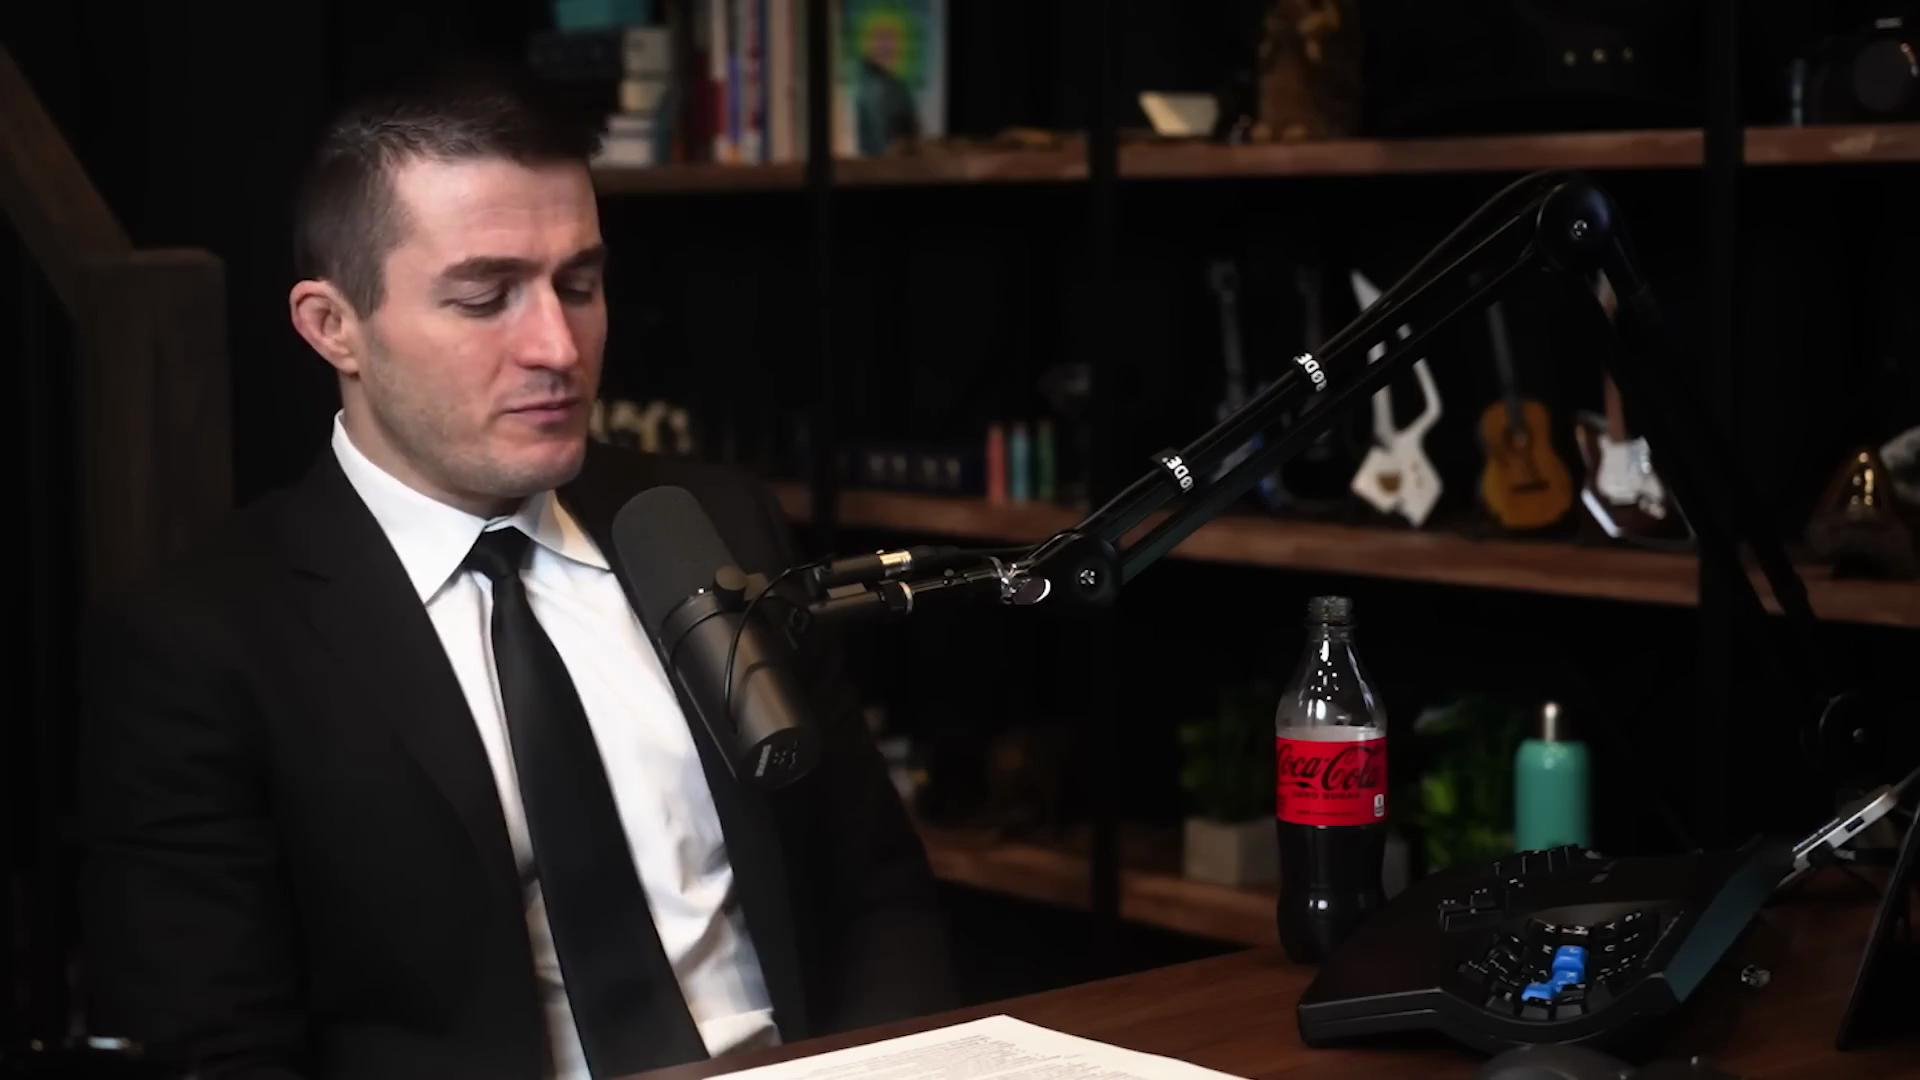
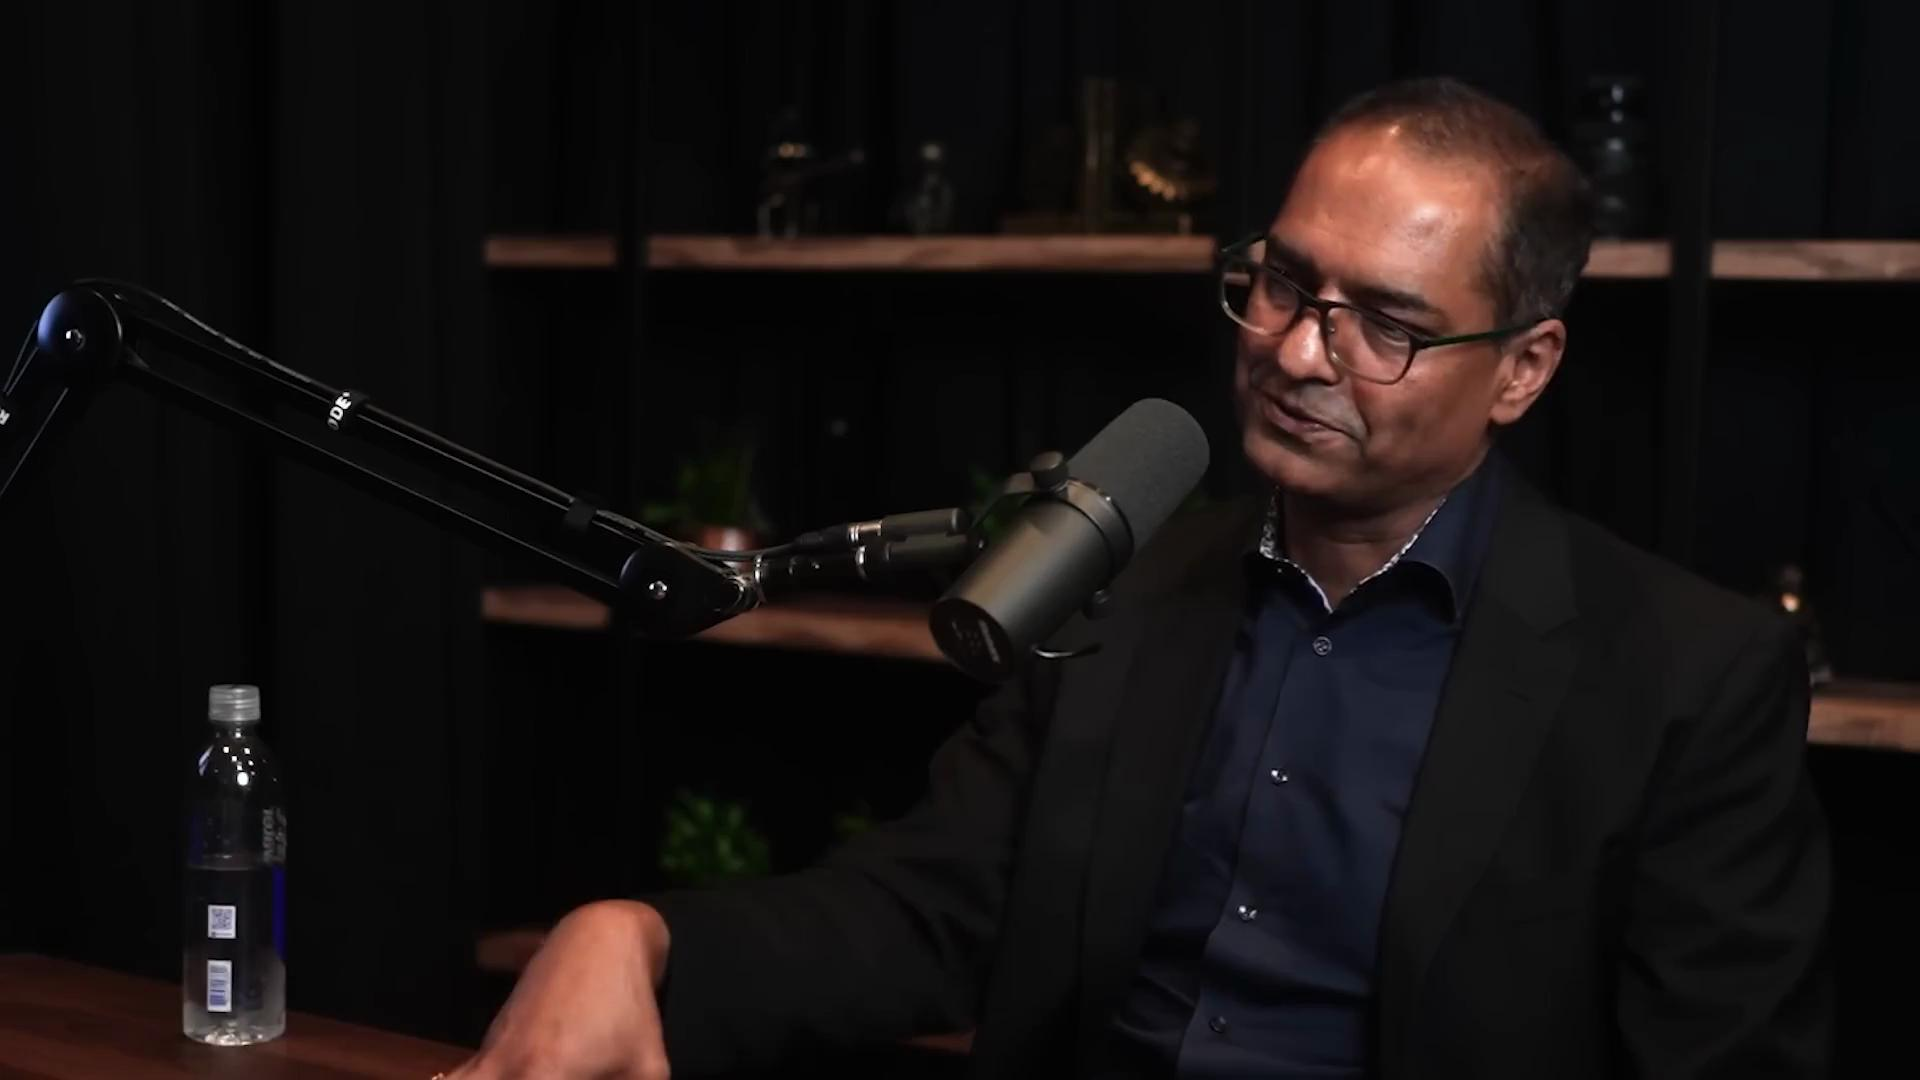
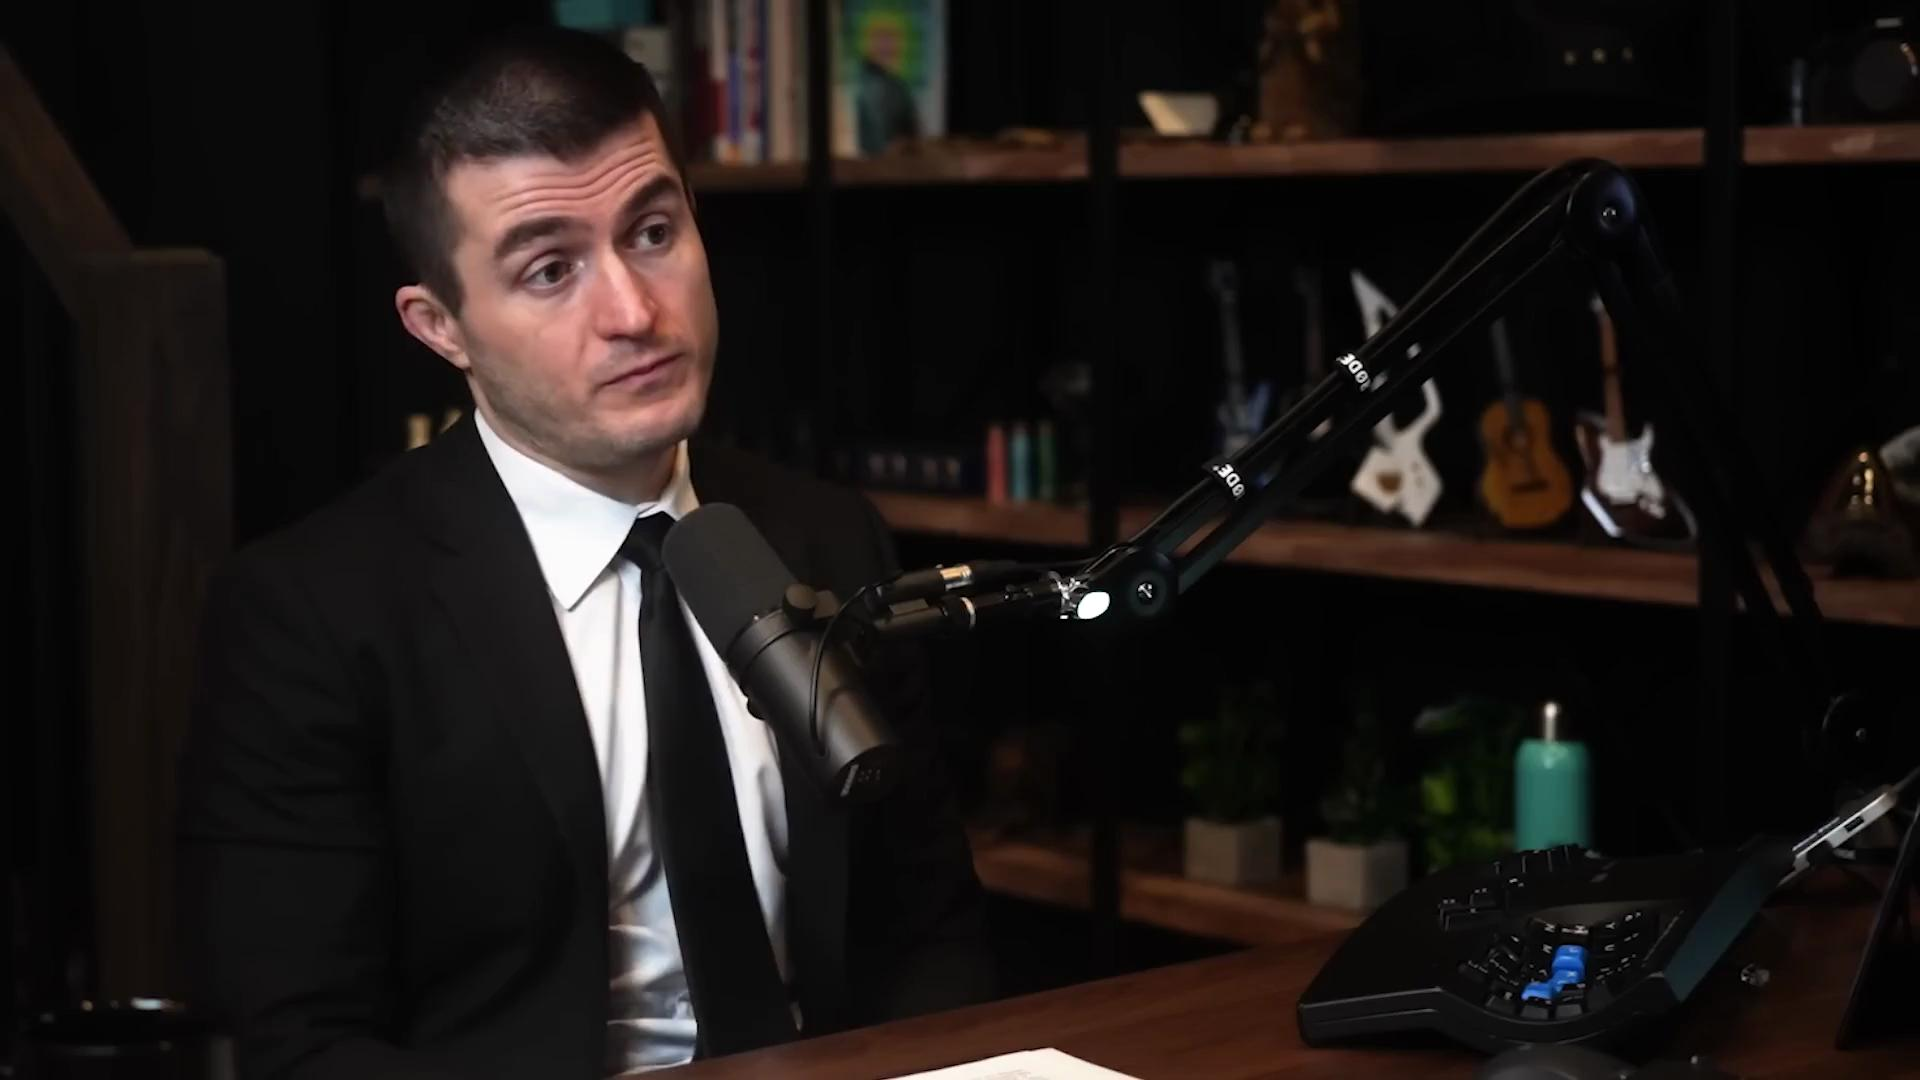

In [12]:
video_table.select(video_table.video, video_table.metadata, video_table.transcription.text).show()

In [13]:
similarity = sentences_view.text.similarity('What is happiness?')
sentences_view.select(sentences_view.text, similarity).order_by(similarity, asc=False).limit(20).collect()

text     col_1
0   Based on the fact that our memories could be a...  0.805073
1   These are chemicals that are released during m...  0.797971
2   I was hoping you can give a simple answer of h...  0.792060
3   Why would we have this period of time that's s...  0.789130
4                                 I want to really be  0.787846
5                       Can I be your opening answer?  0.785402
6       of experiencing self versus remembering self.  0.785325
7                          I need a prefrontal cortex  0.785176
8   And maybe there is some wisdom in the fact tha...  0.784597
9   Essentially some mechanisms for which the brai...  0.783437
10  Attention is a big factor as well, our ability...  0.783245
11                    What's the best way to do that?  0.783154
12  And it's like, I realize I have to redefine wh...  0.775783
13   about reusing information and making the most...  0.774444
14  so I can stay focused on the big picture and t...  0.771843
15   I don't want to be constrained by goals as much.  0.767417
16                                        Or optimal.  0.766948
17                 That was such a great description.  0.766004
18  And so that's why basically again, what you se...  0.758852
19  So one of my colleagues, Amishi Jia, she wrote...  0.756444

We can see the new results showing up in `sentences_view`.

## Using the OpenAI API

This concludes our tutorial using the locally installed Whisper library. Sometimes, it may be preferable to use the OpenAI API rather than a locally installed library. In this section we'll show how this can be done in Pixeltable, simply by using a different function to construct our computed columns.

Since this section relies on calling out to the OpenAI API, you'll need to have an API key, which you can enter below.

In [ ]:
import os
import getpass

if 'OPENAI_API_KEY' not in os.environ:
    os.environ['OPENAI_API_KEY'] = getpass.getpass('OpenAI API Key:')

In [14]:
from pixeltable.functions import openai

video_table['transcription_from_api'] = openai.transcriptions(video_table.audio, model='whisper-1')

Computing cells: 100%|████████████████████████████████████████████| 3/3 [00:09<00:00,  3.03s/ cells]
Added 3 column values with 0 errors.


Now let's compare the results from the local model and the API side-by-side.

video  \
0  /Users/asiegel/.pixeltable/file_cache/7c7641bd...   
1  /Users/asiegel/.pixeltable/file_cache/7c7641bd...   
2  /Users/asiegel/.pixeltable/file_cache/7c7641bd...   

                                  transcription_text  \
0   worse, the young adults had episodic memory. ...   
1   about reusing information and making the most...   
2   of experiencing self versus remembering self....   

                           transcriptionfromapi_text  
0  or worse, the young adults at episodic memory....  
1  about reusing information and making the most ...  
2  of experiencing self versus remembering self, ...
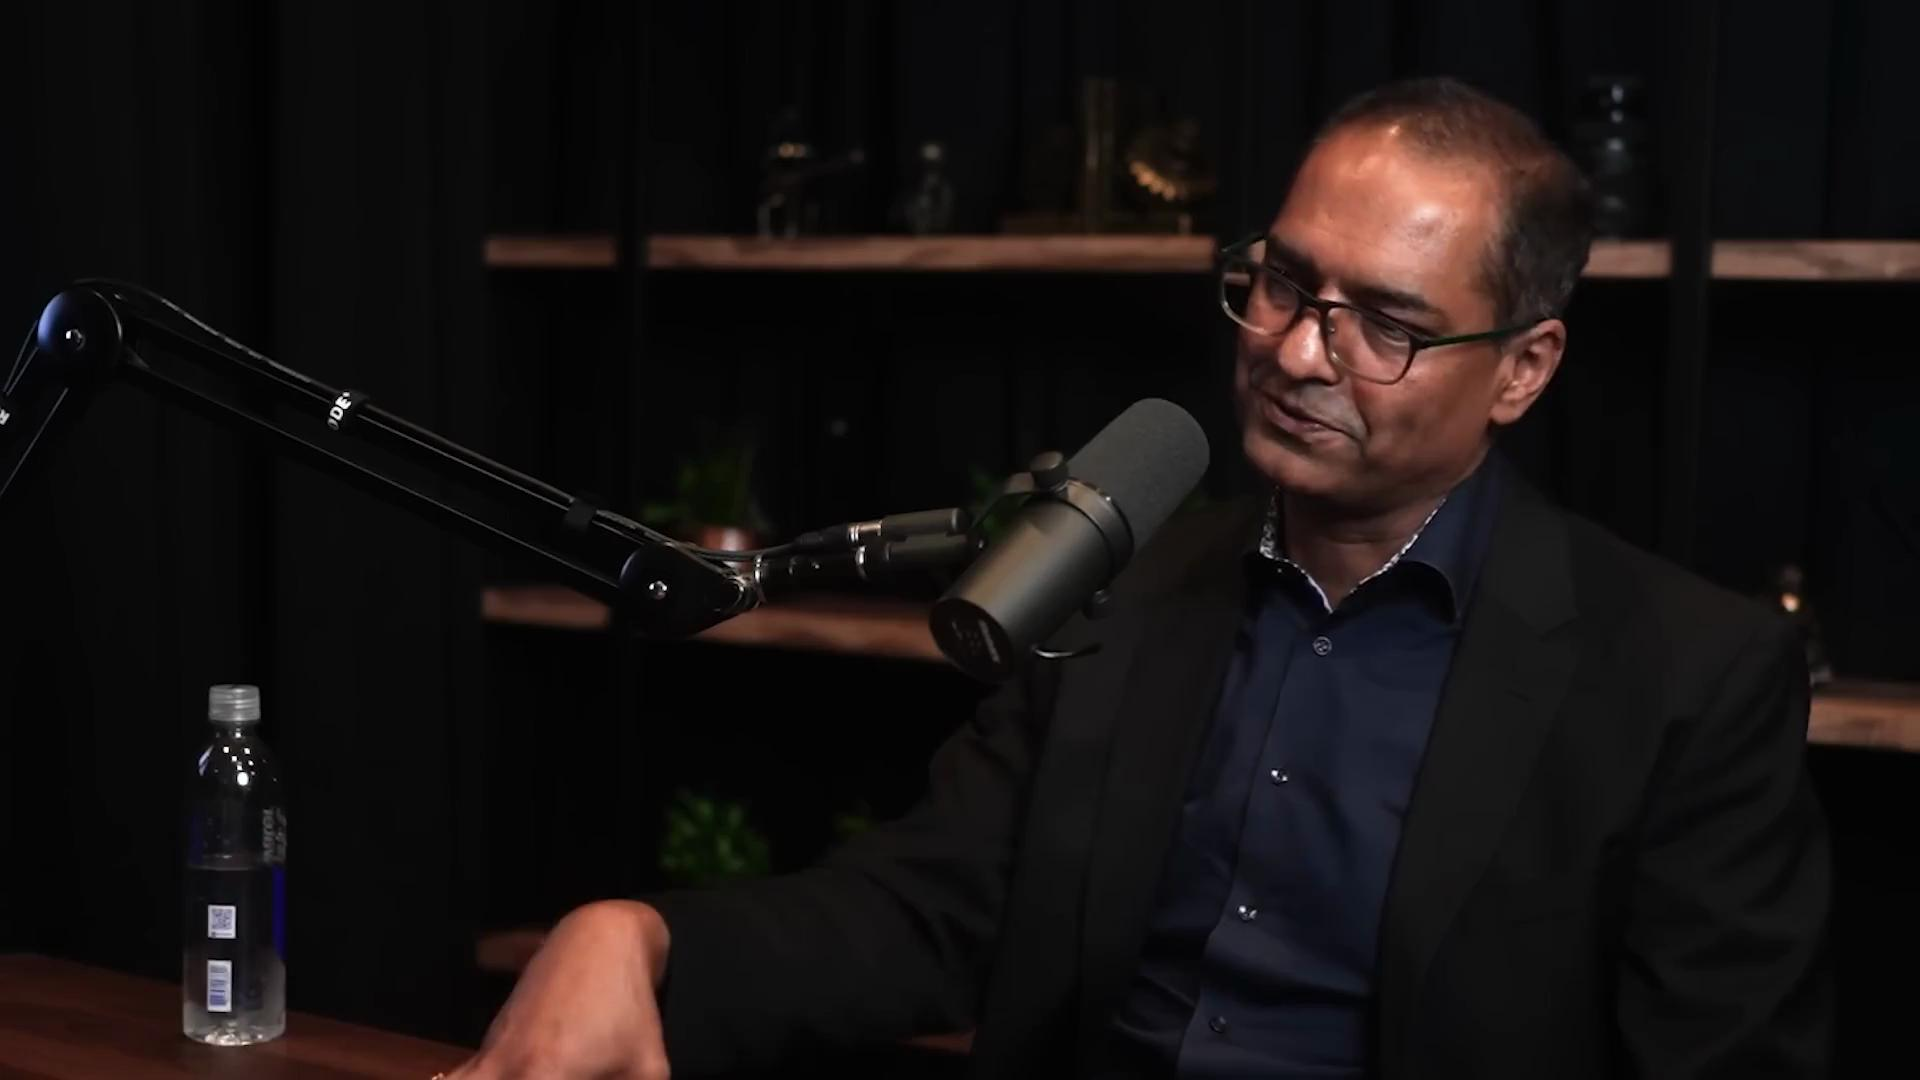
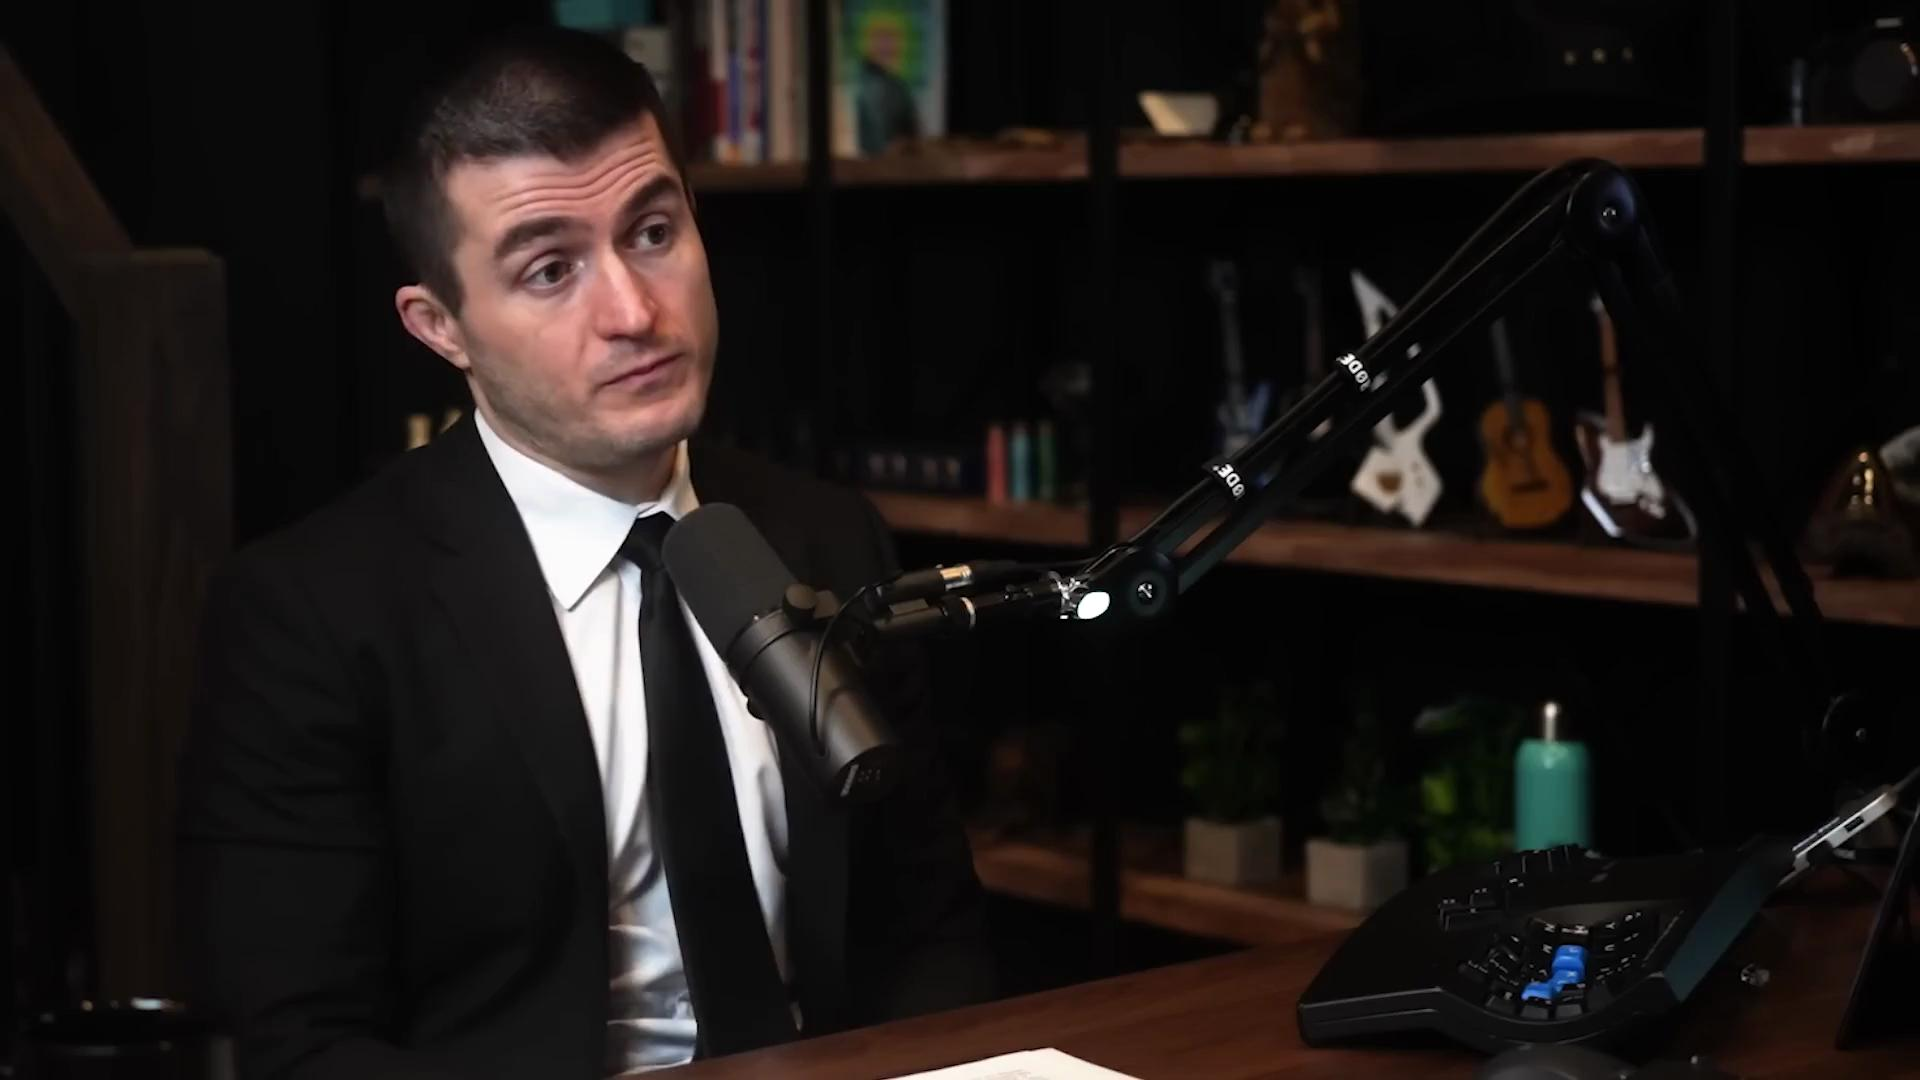
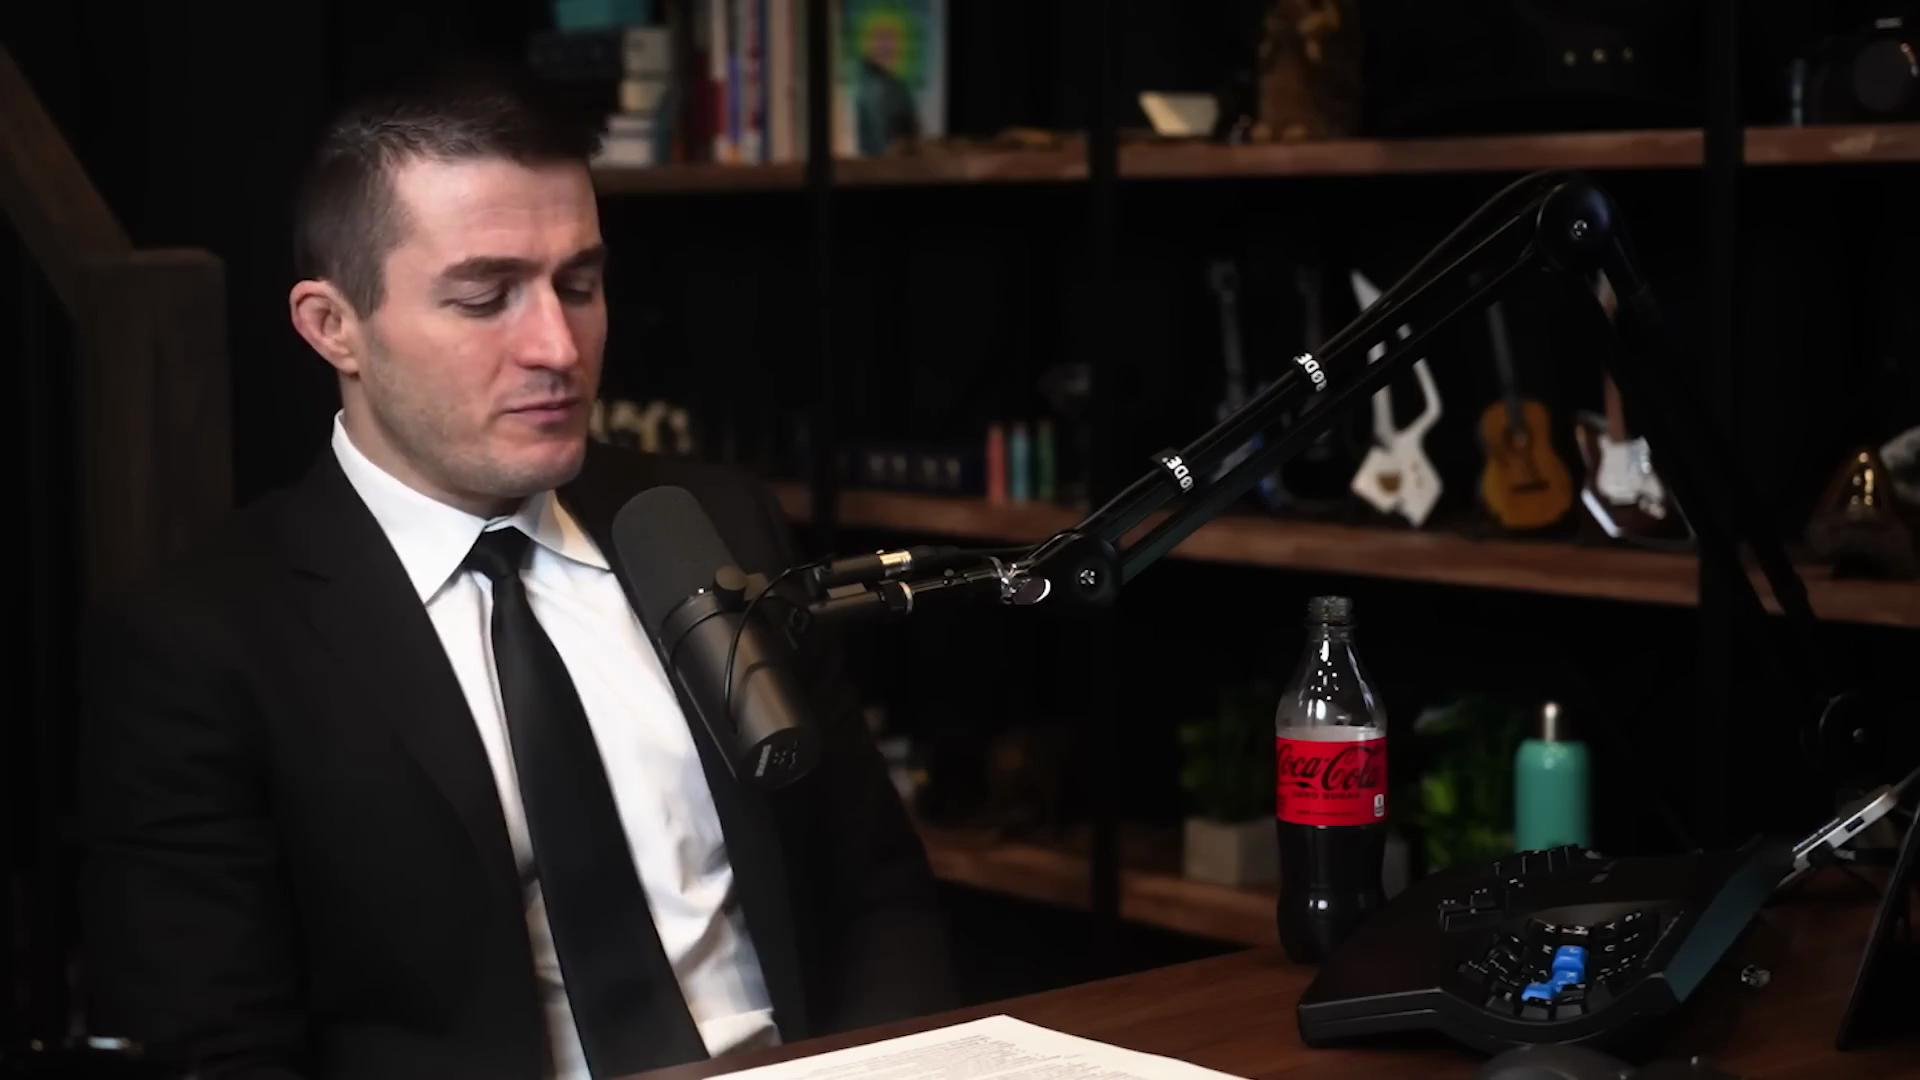

In [15]:
video_table.select(video_table.video, video_table.transcription.text, video_table.transcription_from_api.text).show()

They look pretty similar, which isn't surprising, since the OpenAI transcriptions endpoint runs on Whisper.

One difference is that the local library spits out a lot more information about the internal behavior of the model. Note that we've been selecting `video_table.transcription.text` in the preceding queries, which pulls out just the `text` field of the transcription results. The actual results are a sizable JSON structure that includes a lot of metadata. To see the full output, we can select `video_table.transcription` instead, to get the full JSON struct. Here's what it looks like (we'll select just one row, since it's a lot of output):

In [17]:
video_table.select(video_table.transcription, video_table.transcription_from_api).show(1)

transcription  \
0  {'text': ' worse, the young adults had episodi...   

                              transcription_from_api  
0  {'text': 'or worse, the young adults at episod...